# Imports and Read files

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from IPython.display import clear_output, display
import html
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import unicodedata
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# read generic_tweets
sentiments = pd.read_csv('Sentiment.csv')
sentiments.head()

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


In [0]:
# read canadian_elections
canadian_elections = pd.read_csv('Canadian_elections_2019.csv')
canadian_elections.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


# Data Cleaning

In this section, the two different datasets are cleaned by removing html tags, html codes,mentions and URLs. 

In addition, all words are made lowercase, with stop words removed.

The subsections below are:

    1.1 Generic Tweet(Sentiment.csv) Cleaning
    
    1.2 Canadian Election Tweet Cleaning

## Defining Functions to clean dataset

I defined some functions to remove the "noise" of the tweets text.

In [0]:
def parse(text):
    """
    remove html tags and attributes using beautifulSoup html.parser
    returns output as text
    example: &amp = & in the first line of sentiment data
    """
    soup=BeautifulSoup(text,'html.parser')
    return soup.get_text()

In [0]:
def normalize(text):
    """
    normalizes unicode character to regular text
    Example: normalize('â€¦')='a' in the frist line of sentiment data
    Example: ðÿ‡ºðÿ‡¸ #gopdebateâ€¦ = yoy  #gopdebatea  line 642 of sentiment data
    """
    # read ascii characters using NFKD method, then decode back to string
    text=unicodedata.normalize('NFKD',text).encode('ascii', 'ignore').decode('utf-8')
    return text

In [0]:
def remove_URL(text):
    """
    removes URL
    """

    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'www\S+', '', text)

    return(text)

In [0]:
def remove_mentions(text):
    """
    get rid of tweets mentions.
    """
    text = re.sub(r'@[A-Za-z0-9]+_[A-Za-z0-9]+_[A-Za-z0-9]+','',text)#for user name has three "_"
    text = re.sub(r'@[A-Za-z0-9]+_[A-Za-z0-9]+','',text)#for user name has two "_"
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    
    return text

In [0]:
def remove_spaces(text):
    """
    get rid of  miscellaneous items as well as trailing and leading white spaces
    """
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'-','',text)
    
    return text

In [0]:
def remove_nonletter(text):
    """
    matching anything that is not in the a-z, A-Z(nonletter)
    replace those with white space
    """

    text=re.sub(r'[^a-zA-Z ]+', ' ', text)
    return text

## Cleaning for labeled generic tweet data(sentiments.csv)

In [0]:
#extract text data into a new dataframe
generic_tweet_text = sentiments[['text']]
generic_tweet_text.head()

,text
0,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,I'm listening The Beatles now. They're great
3,@ddlovato could i please get a shout out or an...
4,@salspizza just spotted ur message there Tony ...


In [0]:
#data cleaning
generic_tweet_text_cleaned = generic_tweet_text.apply(lambda x: x.astype(str).str.lower())#lower case
generic_tweet_text_cleaned['text'] = generic_tweet_text_cleaned['text'].apply(parse)
generic_tweet_text_cleaned['text'] = generic_tweet_text_cleaned['text'].apply(normalize)
generic_tweet_text_cleaned['text'] = generic_tweet_text_cleaned['text'].apply(remove_URL)
generic_tweet_text_cleaned['text'] = generic_tweet_text_cleaned['text'].apply(remove_mentions)
generic_tweet_text_cleaned['text'] = generic_tweet_text_cleaned['text'].apply(remove_spaces)
generic_tweet_text_cleaned['text'] = generic_tweet_text_cleaned['text'].apply(remove_nonletter)

In [0]:
generic_tweet_text_cleaned.head()

,text
0,rt they tried to take you out your poll nu...
1,damn i m jealous i wanna watch the fight i l...
2,i m listening the beatles now they re great
3,could i please get a shout out or anything i...
4,just spotted ur message there tony and have r...


In [0]:
# concatenate regular text with cleaned_text
generic_tweet_text_cleaned.columns = ['cleaned_text']
labeled_generic_tweet = pd.concat([sentiments, generic_tweet_text_cleaned], axis=1)
labeled_generic_tweet.head()

,sentiment,text,cleaned_text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,rt they tried to take you out your poll nu...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",damn i m jealous i wanna watch the fight i l...
2,Positive,I'm listening The Beatles now. They're great,i m listening the beatles now they re great
3,Positive,@ddlovato could i please get a shout out or an...,could i please get a shout out or anything i...
4,Positive,@salspizza just spotted ur message there Tony ...,just spotted ur message there tony and have r...


### Remove stopwords and perform Lemmatising

Stopword is defined as commonly used words that can be ignored because they do not add to the meaning of the sentence. For example, these words may include "a", "an", "the" amongst others. By removing the stopwords, it reduces the amount of vocabulary present in the dataset while keeping words that are important.

I decided to remove stopwords from each tweet by using 'stop_words' from the nltk library which provides a list of stopwords. 



In [0]:
# nltk stopwords list
stop_words = set(stopwords.words('english'))
#adding new stopwords
stop_words.add("i'm")
stop_words.add("they're")
stop_words.add("thats")
stop_words.add("tho")
stop_words.add("also")

labeled_generic_tweet['tweets_without_stopwords'] = labeled_generic_tweet['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

Lemmatising each words within a tweet to return each word to root form of a word(no prefix, suffix or infix). This method turns word into its base form.

**Comparison between lemmatising and stemming:**

Lemmatising is chosen over stemming as it is usually more precise than Stemming. Also, the word after lemmatising can be readable by human, however, word after stemming may not readble. Stemming is a crude process that removes the end of the word to attempt to return the word to its base form, where as Lemmatization uses a vocabulary and morphological analysis of the word to return it to its base form. 

Lemmatization is more computationally expensive than stemming, however, given the dataset is small in this analysis, the computation cost is negligable.

In [0]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatising (text):

    words_in_each_tweet = word_tokenize(text)
    final = [lemmatizer.lemmatize(word) for word in words_in_each_tweet]
    stemmed_string = ' '.join(final)
    return stemmed_string

In [0]:
labeled_generic_tweet['tweets_with_lemmer'] = labeled_generic_tweet['tweets_without_stopwords'].apply(lemmatising)

In [0]:
labeled_generic_tweet.head()

,sentiment,text,cleaned_text,tweets_without_stopwords,tweets_with_lemmer
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,rt they tried to take you out your poll nu...,rt tried take poll numbers skyrocketed voters ...,rt tried take poll number skyrocketed voter ma...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",damn i m jealous i wanna watch the fight i l...,damn jealous wanna watch fight love ufc one knows,damn jealous wan na watch fight love ufc one know
2,Positive,I'm listening The Beatles now. They're great,i m listening the beatles now they re great,listening beatles great,listening beatles great
3,Positive,@ddlovato could i please get a shout out or an...,could i please get a shout out or anything i...,could please get shout anything huge fan wait ...,could please get shout anything huge fan wait ...
4,Positive,@salspizza just spotted ur message there Tony ...,just spotted ur message there tony and have r...,spotted ur message tony replied,spotted ur message tony replied


In [0]:
labeled_generic_tweet['tweets_with_lemmer'].isnull().sum()

0

## Cleaning Canadian_elections Dataset

In this section, the canadian election tweets are cleaned based on the same procedure as stated above (lowercase, HTML, URLs, stopwords, stemming, punctuations ...etc.). Some additional steps were taken to consider the differences in the dataset. Besides removing miscellaneous items such as "\", "|", I've also had to remove the following (the code to do so are seen in the block of code following the next one):

    - "\n": new lines
    - "b"", "b'": byte strings
    - "\xf0\x9f\x87\xa8\xf0\x9f\x87": Unicode Hex Characters

In [0]:
#extract text data into a new dataframe
canadian_elections_text = canadian_elections[['text']]
canadian_elections_text.head()

,text
0,"b""@RosieBarton So instead of your suggestion, ..."
1,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [0]:
#data cleaning
canadian_elections_text_cleaned = canadian_elections_text.apply(lambda x: x.astype(str).str.lower())#lower case
canadian_elections_text_cleaned['text'] = canadian_elections_text_cleaned['text'].apply(parse)
canadian_elections_text_cleaned['text'] = canadian_elections_text_cleaned['text'].apply(normalize)
canadian_elections_text_cleaned['text'] = canadian_elections_text_cleaned['text'].apply(remove_URL)
canadian_elections_text_cleaned['text'] = canadian_elections_text_cleaned['text'].apply(remove_mentions)
canadian_elections_text_cleaned['text'] = canadian_elections_text_cleaned['text'].apply(remove_spaces)
# remove words that starts with x (unicode)
canadian_elections_text_cleaned['text'] = canadian_elections_text_cleaned['text'].str.replace(r"\bx\w+", '')

In [0]:
# remove misc items
canadian_elections_text_cleaned = canadian_elections_text_cleaned.replace('-', '', regex=True)
canadian_elections_text_cleaned = canadian_elections_text_cleaned.replace('b"', '', regex=True)
canadian_elections_text_cleaned = canadian_elections_text_cleaned.replace("b'","", regex=True)
canadian_elections_text_cleaned = canadian_elections_text_cleaned.replace(r'\\', '', regex=True)
canadian_elections_text_cleaned = canadian_elections_text_cleaned.replace(r"\\", "", regex=True)
canadian_elections_text_cleaned = canadian_elections_text_cleaned.replace(r"\'s", "s", regex=True)
canadian_elections_text_cleaned = canadian_elections_text_cleaned.replace(r"\'", "", regex=True)
canadian_elections_text_cleaned = canadian_elections_text_cleaned.replace('|', '', regex=True)
# get rid of \n (new lines)
for i in range(len(canadian_elections_text_cleaned)):
    canadian_elections_text_cleaned.text.loc[i] = canadian_elections_text_cleaned.text.loc[i].replace(r'\n', ' ')

In [0]:
canadian_elections_text_cleaned.head()

,text
0,"so instead of your suggestion, how about we a..."
1,#allwomanspacewalk its real!n n#etobicokenorth...
2,#brantford its going to cost you $94 billion f...
3,#canada #canadaelection2019 #canadavotes n#elx...
4,#canada #taxpayers are sick & tired of having ...


In [0]:
# concatenate regular text with cleaned_text
canadian_elections_text_cleaned.columns = ['cleaned_text']
canadian_elections_final = pd.concat([canadian_elections, canadian_elections_text_cleaned], axis=1)
canadian_elections_final.head()

,sentiment,negative_reason,text,cleaned_text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","so instead of your suggestion, how about we a..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",#allwomanspacewalk its real!n n#etobicokenorth...
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",#brantford its going to cost you $94 billion f...
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",#canada #canadaelection2019 #canadavotes n#elx...
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",#canada #taxpayers are sick & tired of having ...


### Remove stopwords and perform Lemmatising

In [0]:
# nltk stopwords list
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

canadian_elections_final['tweets_without_stopwords'] = canadian_elections_final['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

def lemmatising (text):

    words_in_each_tweet = word_tokenize(text)
    final = [lemmatizer.lemmatize(word) for word in words_in_each_tweet]
    stemmed_string = ' '.join(final)
    return stemmed_string

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
canadian_elections_final['tweets_with_lemmer'] = canadian_elections_final['tweets_without_stopwords'].apply(lemmatising)
canadian_elections_final.head()

,sentiment,negative_reason,text,cleaned_text,tweets_without_stopwords,tweets_with_lemmer
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","so instead of your suggestion, how about we a...","instead suggestion, agree #canadian #women tru...","instead suggestion , agree # canadian # woman ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",#allwomanspacewalk its real!n n#etobicokenorth...,#allwomanspacewalk real!n n#etobicokenorth #ci...,# allwomanspacewalk real ! n n # etobicokenort...
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",#brantford its going to cost you $94 billion f...,#brantford going cost $94 billion next 4 years...,# brantford going cost $ 94 billion next 4 yea...
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",#canada #canadaelection2019 #canadavotes n#elx...,#canada #canadaelection2019 #canadavotes n#elx...,# canada # canadaelection2019 # canadavotes n ...
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",#canada #taxpayers are sick & tired of having ...,#canada #taxpayers sick & tired hard earned $ ...,# canada # taxpayer sick & tired hard earned $...


In [0]:
canadian_elections_final['tweets_with_lemmer'].isnull().sum()

0

It appears that we do not have any empty tweet in this dataset.

I concluded that the data cleaning part was completed.

# Exploratory Analysis

In this section, a simple procedure is designed to assign a political party label to each of the tweets. The political parties considered are Liberal, Conservative, NDP and None. 

Furthermore, this section also presents Exploratory Data Analysis (EDA) on both of the datasets (generic tweets and canadian election tweets).

## Hashtags

Firstly, in order to assign a political party label to each one of tweet, we need to get some keywords from hashtag.

The code below extracts hashtags from each of the tweet and shows the top 30 most popular hashtags from the canadian election tweets. Based on the results, it seems that the top 3 most popular ones are "elxn43", "cdnpoli" and "chooseforward".

In [0]:
# create a list of lists, where each sublist holds the hashtags used for that tweet
hashtag_list = []
for i in range(canadian_elections_final.shape[0]):
    tweet = canadian_elections_final['cleaned_text'].loc[i]
    hashtags = re.findall(r"#(\w+)", tweet)
    hashtag_list.append(hashtags)
# create a flattened list of hashtags used
hashtag_list_flat  = [val for sublist in hashtag_list for val in sublist]

# convert flattened hashtag list to dataframe
hashtag_df = pd.DataFrame({'hashtags':hashtag_list_flat})

In [0]:
# the top 30 most used hastags
hashtag_df.hashtags.value_counts().nlargest(30)

elxn43             2060
cdnpoli            1132
chooseforward       158
cpc                  78
trudeaumustgo        75
cdnelxn2019          66
kinsellagate         63
elxn2019             62
canada               58
uprisingh            49
ndp                  44
abpoli               42
onpoli               40
polcan               39
scheerlies           39
elxn43n              37
cdnmedia             36
bcpoli               36
canadavotes2019      35
itsourvote           33
ableg                32
canadavotes          30
ppc2019              28
cndpoli              27
skpoli               26
ppc                  24
scheerdisaster       23
lpc                  23
canpoli              23
andrewscheer         22
Name: hashtags, dtype: int64

## Procedure for determining the political party

In this section, a simple procedure was designed to assign political parties to each tweet based on keywords as well as the hashtags found from previous code segments. 


*   Conservative
*   Liberal
*   NDP
*   None







In [0]:
# keywords/hashtags that represent each party
conservative_party = ['conserv','con','andrew', 'scheer', 'AndrewScheer', 'conservative', 'conservatives', 'cpc_hq', 'cpc', 'ford']
liberal_party = ['liber','lib','justin', 'trudeau', 'JustinTrudeau', 'liberal', 'liberals', 'timlouis', 'chooseforward', 'chooseforwardwithtrudeau', 'teamtrudeau', 'votingliberal']
NDP_party = ['jagmeet', 'singh', 'theJagmeetSingh', 'uprisingh', 'ndp']

In [0]:
# create dataframe that holds keywords/hashtags for each party
conservative = canadian_elections_final[canadian_elections_final['cleaned_text'].str.contains('|'.join(conservative_party))]
liberal = canadian_elections_final[canadian_elections_final['cleaned_text'].str.contains('|'.join(liberal_party))]
NDP = canadian_elections_final[canadian_elections_final['cleaned_text'].str.contains('|'.join(NDP_party))]

In [0]:
# create a new column
canadian_elections_final['Party'] = ''

# fill the party column with the respective parties
for index in (liberal.index.tolist()):
        canadian_elections_final['Party'].loc[index] = 'Liberal'
for index in (conservative.index.tolist()):
        canadian_elections_final['Party'].loc[index] = 'Conservative'
for index in (NDP.index.tolist()):
        canadian_elections_final['Party'].loc[index] = 'NDP'

        
# fill all the unassigned Party values with None
canadian_elections_final.Party.replace("", "None", inplace=True)

As we can see the distributions below, half the election tweets were assigned "None". Conservative party (734) was ranked in second place followed by the rest three parties.

In [0]:
canadian_elections_final['Party'].value_counts()

None            900
Conservative    734
Liberal         293
NDP             206
Name: Party, dtype: int64

## Visualization

In this section, some figures are shown to visualize the two datasets. 

- Word Clouds (Both Dataset)
- Three parties count (Election data)
- Sentiment count for each party (Election data)
- Negative reason Distribution visulize(Election data)

### **Bonus**:Number of tweets for each Party

The plot below shows that the majority of the tweets (nearly 50%) do not have an associated label (None) while Liberal and Conservative's are the second and third most popular, respectively. The NDP and PPC parties combine for roughly 28% of the data. 

It is important to note that this result is based on the simple procedure designed in previous section; therefore, it is not an accurate representation of the actual landscape of the political party's mentions on Twitter.

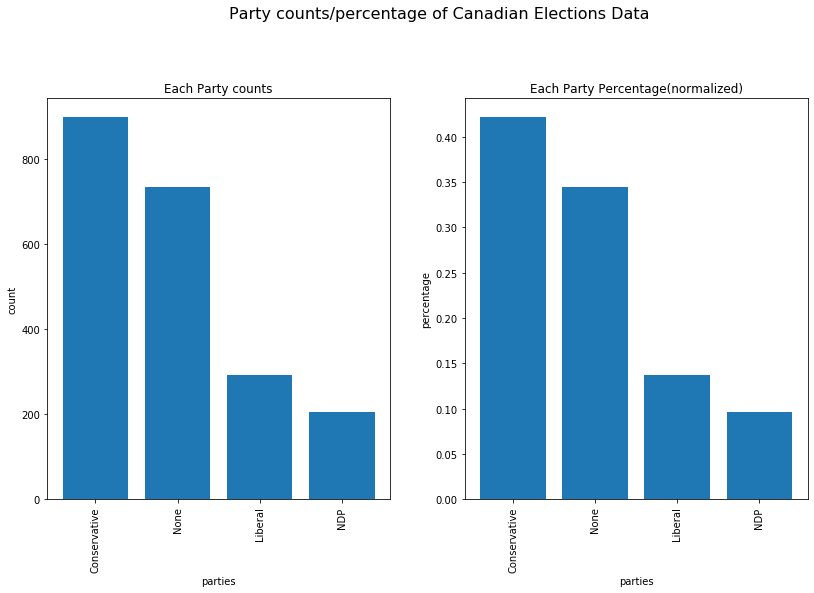

In [0]:
# Create two subplots and unpack the output array immediately
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,7))
fig.suptitle('Party counts/percentage of Canadian Elections Data', fontsize=16,y=1.15)
fig.tight_layout(pad = 21)
ax1.bar(canadian_elections_final['Party'].unique(),canadian_elections_final['Party'].value_counts(),)
ax1.set_title('Each Party counts')
ax1.set_xticklabels(canadian_elections_final['Party'].unique(), rotation=90 )
ax1.set_xlabel('parties')
ax1.set_ylabel('count')
ax2.bar(canadian_elections_final['Party'].unique(),canadian_elections_final['Party'].value_counts(normalize=True))
ax2.set_xticklabels(canadian_elections_final['Party'].unique(), rotation=90 )
ax2.set_title('Each Party Percentage(normalized)')
ax2.set_xlabel('parties')
ax2.set_ylabel('percentage')

plt.tight_layout(pad=0.0001)
plt.show()

### Word Clouds for both datasets

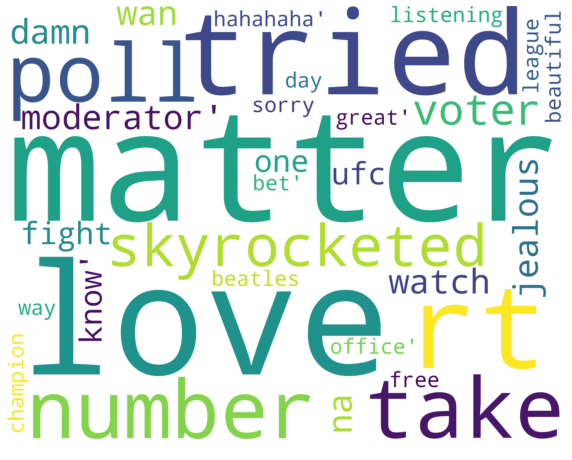

In [0]:
# create wordcloud on the lemmtised text
text = labeled_generic_tweet['tweets_with_lemmer'].values
wordcloud = WordCloud(width = 5000, height = 4000, background_color="white").generate(str(text))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

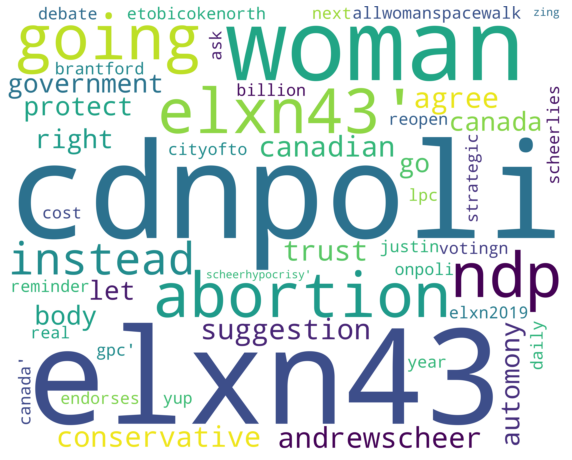

In [0]:
# create wordcloud on the lemmtised text
text = canadian_elections_final['tweets_with_lemmer'].values
wordcloud = WordCloud(width = 5000, height = 4000, background_color="white").generate(str(text))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### **Bonus**:The number of positive & negative tweets that relate each party

three parties negative tweets all more than positive tweets, 'Conservative' has highest number of etheir pos/neg tweets, and number of negative tweets nearly doubled.

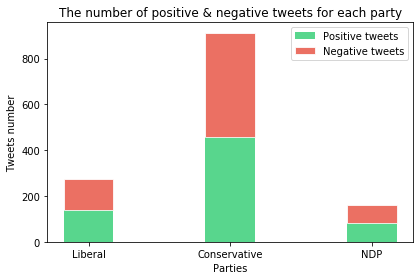

In [0]:
# plot the bar chart
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

a = canadian_elections_final[canadian_elections_final['sentiment']=='Negative']
negative_count_liberal = len(a[a['Party']=='Liberal'])
negative_count_conservative = len(a[a['Party']=='Conservative'])
negative_count_NDP = len(a[a['Party']=='NDP'])
negative_count_total = [negative_count_liberal,negative_count_conservative,negative_count_NDP]


b = canadian_elections_final[canadian_elections_final['sentiment']=='Positive']
positive_count_liberal = len(a[a['Party']=='Liberal'])
positive_count_conservative = len(a[a['Party']=='Conservative'])
positive_count_NDP = len(a[a['Party']=='NDP'])
positive_count_total = [positive_count_liberal,positive_count_conservative,positive_count_NDP]


plt.bar(index, positive_count_total, bar_width, alpha=opacity, 
        color='#2ECC71', label='Positive tweets')
plt.bar(index, negative_count_total, bar_width, alpha=opacity, bottom=positive_count_total,
        color='#E74C3C', edgecolor='white', label='Negative tweets')

plt.xlabel('Parties')
plt.ylabel('Tweets number')
plt.title('The number of positive & negative tweets for each party')
plt.xticks(index, ('Liberal', 'Conservative', 'NDP'))
plt.legend()
plt.tight_layout()
plt.show()

### **Bonus**:pie chart for negative reason

Here I plot the negative reasons pie chart, we can clearly see each reason take specifice portion, 'Other' takes up 36.2%, followed by 'scandal' and 'tell lies', which them are 26.8% and 19.7 %; for the rest of negative reasons all less than 10 %. 

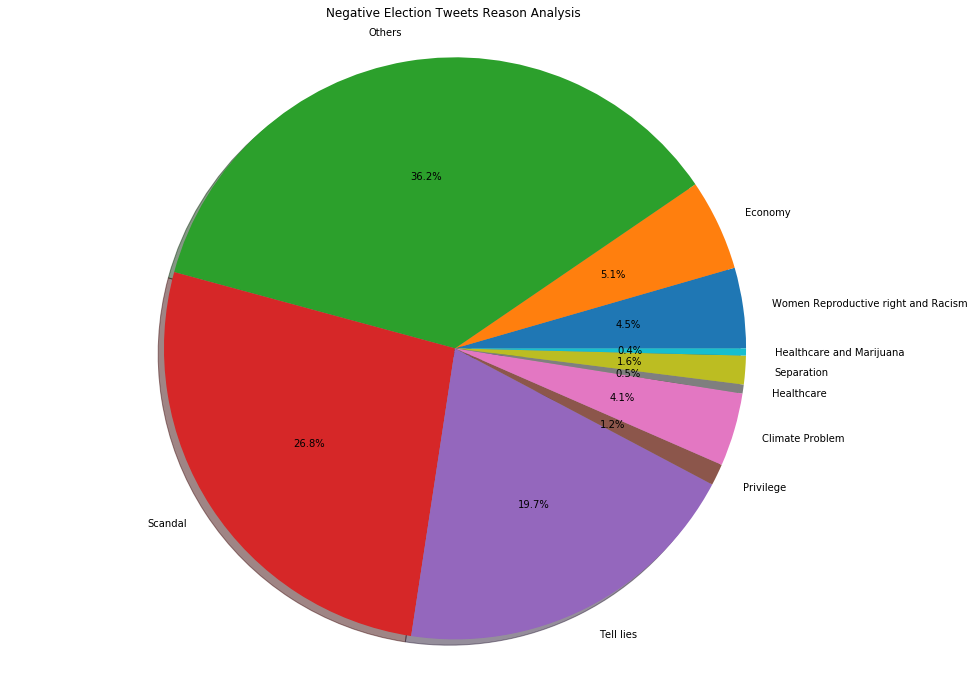

In [0]:
negative_reason_list = ['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana']

sizes = []
for reason in negative_reason_list :
  sizes.append(canadian_elections_final[canadian_elections_final['negative_reason'] == reason].shape[0])

plt.figure(figsize=(16, 12))
plt.pie(sizes, labels=negative_reason_list, autopct='%1.1f%%', shadow=True)
plt.title('Negative Election Tweets Reason Analysis')
plt.axis('equal')
plt.show()

# Model Preparation

In this section, 7 different classification models are built with 2 different types of features. 
    
    Models: logistic regression, k-NN, Naive Bayes, SVM, Decision Trees, Random Forest and XGBoost.
 
The 2 different types of features are 
Bag of Words (Word Frequency) and  

*   Bag of Words (Word Frequency)
*   Term Frequency - Inverse Document Frequency(TF-IDF)

The goal is to predict the sentiment label of each tweet in the generic tweet dataset.

## Count Vectorizer (Bag of Words)

I tried to generate the bag of words (WF) matrix of the generic tweets. This technique represents a count of the respective word from a bag of words that are deemed most frequent. It assumes that the most important keywords occur more often than words that are not.

To implement this, I used the countvectorizer function with a maximum feature number of 600. The higher the feature number, the more information will be retained for each tweet; however, I realised that I had to bound the feature size in order to avoid crashing and huge sparse matrix creation, so that I set my maximum features to 600 performed on the lemmitised tweets.



In [0]:
sentiment_csv_cleandata = labeled_generic_tweet['tweets_with_lemmer']

In [0]:
# count vectorizer to create a 1D vector for each tweet
vectorizer = CountVectorizer(max_features = 600)
count_vector = vectorizer.fit_transform(sentiment_csv_cleandata.values.astype('U'))
count_array = count_vector.toarray()

# encodes generic tweets
CountVec_features = pd.DataFrame(data=count_array, columns = vectorizer.get_feature_names())
CountVec_features.head()

,able,actually,add,afternoon,ago,agree,ah,almost,alone,already,...,xx,ya,yay,yea,yeah,year,yes,yesterday,yet,yoy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF

The second type of feature used is called "Term Frequency-Inverse Document Frequency" (TF-IDF), it is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The idea here is that words that appears often are in fact not important; whereas, words that appear less frequent contribute more to the overall importance.  

In [0]:
# tf-idf vectorizer to create a 1D vector for each tweet
tfidf_vectorizer = TfidfVectorizer(max_features = 600,use_idf=True, smooth_idf=True, norm=None)
tfidf_vec = tfidf_vectorizer.fit_transform(sentiment_csv_cleandata.values.astype('U'))
tfidf_array = tfidf_vec.toarray()

# encodes generic tweet
TFIDF_features = pd.DataFrame(data=tfidf_array, columns = tfidf_vectorizer.get_feature_names())
TFIDF_features.head()

,able,actually,add,afternoon,ago,agree,ah,almost,alone,already,...,xx,ya,yay,yea,yeah,year,yes,yesterday,yet,yoy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preparing Testing and Training Data 

Split both the datasets above into testing set (30%) and training set. (70%)

In [0]:
labeled_generic_tweet['sentiment'].value_counts()

Negative    71428
Positive    59241
Neutral      3142
Name: sentiment, dtype: int64

In [0]:
#concat sentiment labels with two features together
gen_tweet_WF_features = pd.concat([labeled_generic_tweet['sentiment'], CountVec_features], axis=1)
gen_tweet_TFIDF_features = pd.concat([labeled_generic_tweet['sentiment'], TFIDF_features], axis=1)
#drop 'Neutral' because we only need either 'positive' or 'negative'
gen_tweet_TFIDF_features.drop(gen_tweet_TFIDF_features[gen_tweet_TFIDF_features['sentiment'] == 'Neutral'].index,inplace=True)
gen_tweet_WF_features.drop(gen_tweet_WF_features[gen_tweet_WF_features['sentiment'] == 'Neutral'].index,inplace=True)

In [0]:
label_encoding = {"Positive":1,"Negative":0}
gen_tweet_TFIDF_features.loc[0:,'labels'] = gen_tweet_TFIDF_features.loc[0:,'sentiment'].map(label_encoding)
gen_tweet_TFIDF_features.drop(['sentiment'],axis=1,inplace=True)

In [0]:
gen_tweet_WF_features.loc[0:,'labels'] = gen_tweet_WF_features.loc[0:,'sentiment'].map(label_encoding)
gen_tweet_WF_features.drop(['sentiment'],axis=1,inplace=True)

In [0]:
# Split test (30%) and train (70%) data for Word Frequency features
X_WF = gen_tweet_WF_features.drop(['labels'], axis=1)
y_WF = gen_tweet_WF_features['labels']
X_WF_train, X_WF_test, y_WF_train, y_WF_test = train_test_split(X_WF, y_WF, random_state=40, test_size=0.3)

# Split test (30%) and train (70%) data for TF-IDF features
X_tfidf = gen_tweet_TFIDF_features.drop(['labels',], axis=1)
y_tfidf = gen_tweet_TFIDF_features['labels']
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_tfidf, random_state=55, test_size=0.3)

# Model Implementation

Some models take a really long time to run; therefore, I have saved the trained classifier models to my local disk.

**Every single model here will be implmented as its default setting, after get the best model based on accuracy score, I will tune the best model only.**

In [0]:
# to save the models
import pickle

## Logistic Regression Model

I implemented the Logistic Regression model for both features created before(word frequency and tf-idf), trained on the training dataset, and then applied the model to the testing dataset to obtain an accuracy value. I set n_jobs to -1 in order to run as many parallel jobs as it could, other parameters of model stay default.

**Pros:**
*   Convenient probability scores for observations
*   Multi-collinearity is not really an issue and can be countered with L2 regularization to an extent
*   popular classification model

**Cons:**
*   Doesn’t perform well when feature space is too large
*   Relies on entire data
*   Doesn’t handle large number of categorical features/variables well

In [0]:
from sklearn.linear_model import LogisticRegression

### For Word Frequency Feature

In [0]:
%%time
Logistic_WF_model = LogisticRegression()
Logistic_WF_model.fit(X_WF_train, y_WF_train)
score_logistic_wf = Logistic_WF_model.score(X_WF_test, y_WF_test)

Wall time: 922 ms


In [0]:
filename = 'Logistic_WF_model.sav'
pickle.dump(Logistic_WF_model, open(filename, 'wb'))

In [0]:
print("The accuracy of logistic regression model for word frequency feature is:{}%".format(round(score_logistic_wf*100, 5)))

The accuracy of logistic regression model for word frequency feature is:72.5058%


### For TF-IDF feature

In [0]:
%%time
Logistic_tfidf_model = LogisticRegression()
Logistic_tfidf_model.fit(X_tfidf_train, y_tfidf_train)
score_logistic_tfidf = Logistic_tfidf_model.score(X_tfidf_test, y_tfidf_test)

Wall time: 790 ms


In [0]:
filename = 'Logistic_tfidf_model.sav'
pickle.dump(Logistic_tfidf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of logistic regression model for TF-IDF feature is:{}%".format(round(score_logistic_tfidf*100, 5)))

The accuracy of logistic regression model for TF-IDF feature is:72.24561%


## k-NN Model

I implemented the k-nn model for both features created before(word frequency and tf-idf), trained on the training dataset, and then applied the model to the testing dataset to obtain an accuracy value. I set n_jobs to -1 in order to run as many parallel jobs as it could, other parameters of model stay default.

K- Nearest Neighbors is a Supervised machine learning algorithm as target variable is known Non parametric as it does not make an assumption about the underlying data distribution pattern. Lazy algorithm as KNN does not have a training step. 

**pros:**
*   Simple algorithm and hence easy to interpret the prediction
*   Non parametric, so makes no assumption about the underlying data pattern

**cons:**
*   KNN is computationally expensive as it searches the nearest neighbors for the new point at the prediction stage
*   High memory requirement as KNN has to store all the data points
*   Sensitive to outliers, accuracy is impacted by noise or irrelevant data.
*   Prediction stage is very costly

In [0]:
from sklearn.neighbors import KNeighborsClassifier

### for Word Frequency Feature

In [0]:
%%time
KNN_WF_model = KNeighborsClassifier()
KNN_WF_model.fit(X_WF_train, y_WF_train)
score_knn_wf = KNN_WF_model.score(X_WF_test, y_WF_test)

Wall time: 45min 17s


In [0]:
filename = 'KNN_WF_model.sav'
pickle.dump(KNN_WF_model, open(filename, 'wb'))

In [0]:
print("The accuracy of knn model for word frequency feature is:{}%".format(round(score_knn_wf*100, 5)))

The accuracy of knn model for word frequency feature is:66.30698%


### For TF-IDF feature

In [0]:
%%time
KNN_tfidf_model = KNeighborsClassifier()
KNN_tfidf_model.fit(X_tfidf_train, y_tfidf_train)
score_knn_tfidf = KNN_tfidf_model.score(X_tfidf_test, y_tfidf_test)

Wall time: 35min 35s


In [0]:
filename = 'KNN_tfidf_model.sav'
pickle.dump(KNN_tfidf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of knn model for TF-IDF feature is:{}%".format(round(score_knn_tfidf*100, 5)))

The accuracy of knn model for TF-IDF feature is:65.50088%


## Naive Bayes Model

In [0]:
from sklearn.naive_bayes import GaussianNB

**Pros:**
*   Computationally fast
*   Simple to implement
*   Works well with high dimensions


**Cons:**
*   Relies on independence assumption and will perform badly if this assumption is not met


### For Word Frequecy Feature

In [0]:
%%time
NB_WF_model = GaussianNB()
NB_WF_model.fit(X_WF_train, y_WF_train)
score_nb_wf = NB_WF_model.score(X_WF_test, y_WF_test)

Wall time: 1.77 s


In [0]:
filename = 'NB_WF_model.sav'
pickle.dump(NB_WF_model, open(filename, 'wb'))

In [0]:
print("The accuracy of Naive Bayes model for word frequency feature is:{}%".format(round(score_nb_wf*100, 5)))

The accuracy of Naive Bayes model for word frequency feature is:67.46256%


### For TF-IDF Feature

In [0]:
%%time
NB_tfidf_model = GaussianNB()
NB_tfidf_model.fit(X_tfidf_train, y_tfidf_train)
score_nb_tfidf = NB_tfidf_model.score(X_tfidf_test, y_tfidf_test)

Wall time: 1.74 s


In [0]:
filename = 'NB_tfidf_model.sav'
pickle.dump(NB_tfidf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of Naive Bayes model for TF-IDF feature is:{}%".format(round(score_nb_tfidf*100, 5)))

The accuracy of Naive Bayes model for TF-IDF feature is:66.80952%


## SVM Model

In classification, SVM fits hyperplane to feature space to linearly seperate the classes. A hyperplane being a space that is one dimension lower than the feature space. It can use a kernel function to map the feature space to a higher dimension. Doing this will allow features to become seperable, i.e. becomes linear. 


**Pros:**
- It has a built in regularization parameter, C that helps with over fitting.
- Different kernels can handle different types of non-lineraity. Giving it a better handle on high-dimension datasets. 

**Cons:**
- Can be difficult to tune due to different kernels would need different parameters.
- It's slow compared to other linear classification models.

In [0]:
from sklearn.svm import SVC

### For Word Frequency Feature

In [0]:
%%time
SVM_wf_model = SVC()
SVM_wf_model.fit(X_WF_train, y_WF_train)
score_svm_wf = SVM_wf_model.score(X_WF_test, y_WF_test)

Wall time: 2h 3min 15s


In [0]:
filename = 'SVM_wf_model.sav'
pickle.dump(SVM_wf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of SVM model for word frequency feature is:{}%".format(round(score_svm_wf*100, 5)))

The accuracy of SVM model for word frequency feature is:70.64361%


### For TF-IDF feature

In [0]:
%%time
SVM_tfidf_model = SVC()
SVM_tfidf_model.fit(X_tfidf_train, y_tfidf_train)
score_svm_tfidf = SVM_tfidf_model.score(X_tfidf_test, y_tfidf_test)

Wall time: 1h 56min 43s


In [0]:
filename = 'SVM_tfidf_model.sav'
pickle.dump(SVM_tfidf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of SVM model for TF-IDF feature is:{}%".format(round(score_svm_tfidf*100, 5)))

The accuracy of SVM model for TF-IDF feature is:72.56703%


## Decision Tree Model

In [0]:
from sklearn.tree import DecisionTreeClassifier

**Pros:**
*   easy to interpret visually when the trees only contain several levels
*   Can easily handle qualitative (categorical) features
*   Works well with decision boundaries parellel to the feature axis


**Cons:**
*   prone to overfitting
*   possible issues with diagonal decision boundaries



### For Word Frequency Feature

In [0]:
%%time
DT_wf_model = DecisionTreeClassifier(random_state=0)
DT_wf_model.fit(X_WF_train, y_WF_train)
score_dt_wf = DT_wf_model.score(X_WF_test, y_WF_test)

Wall time: 46.4 s


In [0]:
filename = 'DT_wf_model.sav'
pickle.dump(DT_wf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of Decision Tree model for word frequency feature is:{}%".format(round(score_dt_wf*100, 5)))

The accuracy of Decision Tree model for word frequency feature is:66.86309%


### For TF-IDF Feature

In [0]:
%%time
DT_tfidf_model = DecisionTreeClassifier(random_state=0)
DT_tfidf_model.fit(X_tfidf_train, y_tfidf_train)
score_dt_tfidf = DT_tfidf_model.score(X_tfidf_test, y_tfidf_test)

Wall time: 46.9 s


In [0]:
filename = 'DT_tfidf_model.sav'
pickle.dump(DT_tfidf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of Decision Tree model for TF-IDF feature is:{}%".format(round(score_dt_tfidf*100, 5)))

The accuracy of Decision Tree model for TF-IDF feature is:66.76105%


## Random Forest Model

In [0]:
from sklearn.ensemble import RandomForestClassifier

**Pros:**
*   Decorrelates trees (relative to bagged trees)
*   important when dealing with mulitple features which may be correlated
*   reduced variance (relative to regular trees)

**Cons:**
*   Not as easy to visually interpret
*   many hyperparamters

### For word Frequency Feature

In [0]:
%%time
RF_wf_model = RandomForestClassifier()
RF_wf_model.fit(X_WF_train, y_WF_train)
score_rf_wf = RF_wf_model.score(X_WF_test, y_WF_test)

Wall time: 16.2 s


In [0]:
filename = 'RF_wf_model.sav'
pickle.dump(RF_wf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of Random Forest model for word frequency feature is:{}%".format(round(score_rf_wf*100, 5)))

The accuracy of Random Forest model for word frequency feature is:69.79159%


### For TF-IDF Feature

In [0]:
%%time
RF_tfidf_model = RandomForestClassifier()
RF_tfidf_model.fit(X_tfidf_train, y_tfidf_train)
score_rf_tfidf = RF_tfidf_model.score(X_tfidf_test, y_tfidf_test)

Wall time: 16.3 s


In [0]:
filename = 'RF_tfidf_model.sav'
pickle.dump(RF_tfidf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of Random Forest model for TF-IDF feature is:{}%".format(round(score_rf_tfidf*100, 5)))

The accuracy of Random Forest model for TF-IDF feature is:69.57476%


## XGBoost Model

In [0]:
#!pip install xgboost
import xgboost as xgb

**Pros:**
*   Somewhat more interpretable than bagged trees/random forest as the user can define the size of each tree resulting in a collection of stumps (1 level) which can be viewed as an additive model
*   Can easily handle qualitative (categorical) features

**Cons:**
*   Unlike bagging and random forests, can overfit if number of trees is too large

### For Word Frequency Feature

In [0]:
%%time
xgb_wf_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_wf_model.fit(X_WF_train, y_WF_train)
score_xgb_wf = xgb_wf_model.score(X_WF_test, y_WF_test)

Wall time: 1min 12s


In [0]:
filename = 'xgb_wf_model.sav'
pickle.dump(xgb_wf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of XGBoost model for word frequency feature is:{}%".format(round(score_xgb_wf*100, 5)))

The accuracy of XGBoost model for word frequency feature is:72.3706%


### For TF-IDF Feature

In [0]:
%%time
xgb_tfidf_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_tfidf_model.fit(X_tfidf_train, y_tfidf_train)
score_xgb_tfidf = xgb_tfidf_model.score(X_tfidf_test, y_tfidf_test)

Wall time: 1min 12s


In [0]:
filename = 'xgb_tfidf_model.sav'
pickle.dump(xgb_tfidf_model, open(filename, 'wb'))

In [0]:
print("The accuracy of XGBoost model for TF-IDF feature is:{}%".format(round(score_xgb_tfidf*100, 5)))

The accuracy of XGBoost model for TF-IDF feature is:72.5007%


## Results for 7 Models above and pick the best one

Below is the result datafram which shows the accuracy score for seven different model.

In [0]:
model_name = np.array([['Logistic Regression'], ['k-NN'], ['Naive Bayes'], ['SVM'], ['Decision Tree'],
                       ['Random Forest'], ['XGBoost']])
wf_accuracy = np.array([[round(score_logistic_wf*100, 3)], [round(score_knn_wf*100, 3)],
              [round(score_nb_wf*100, 3)], [round(score_svm_wf*100, 3)],
              [round(score_dt_wf*100, 3)], [round(score_rf_wf*100, 3)],
              [round(score_xgb_wf*100, 3)]])
tfidf_accuracy = np.array([[round(score_logistic_tfidf*100, 3)], [round(score_knn_tfidf*100, 3)],
              [round(score_nb_tfidf*100, 3)], [round(score_svm_tfidf*100, 3)],
              [round(score_dt_tfidf*100, 3)], [round(score_rf_tfidf*100, 3)],
              [round(score_xgb_tfidf*100, 3)]])  
result_np = np.concatenate((model_name, wf_accuracy, tfidf_accuracy), axis=1) 
Result = pd.DataFrame(result_np)
Result.columns = ['model', 'bag of words', 'tf-idf']
Result

,model,bag of words,tf-idf
0,Logistic Regression,72.506,72.246
1,k-NN,66.307,65.501
2,Naive Bayes,67.463,66.81
3,SVM,70.644,72.567
4,Decision Tree,66.863,66.761
5,Random Forest,69.792,69.575
6,XGBoost,72.371,72.501


### Hyperparameter Tuning for Best Model

Since the run time for SVM(best model) is the longest, usually takes 2-3 hrs to finish. If I implemented grid search on this model, the runing time will be more than a day. 
Thus, **I decided to not tune hyperparameter of the Best model**, but I will leave the code below for future tuning.

***Best model is the SVM with default setting.***

In [0]:
# grid_values = {'C':[1,10,100],'gamma':[1,0.1], 'kernel':['rbf']}
# grid = GridSearchCV(SVM_tfidf_model, param_grid = grid_values,cv=5,scoring = 'accuracy', refit = True, verbose = 3)
# best_result = grid.fit(X_tfidf_train, y_tfidf_train)

In [0]:
# print('Best C:', best_result.best_estimator_.get_params()['C'])
# print("Best accuracy :",best_result.best_score_)
# print('Best gamma:', best_result.best_estimator_.get_params()['gamma'])

In [0]:
print("The runing time for tuning hyperparameter with best performance is too long.")
print("The code above is for hyperparameter tuning of SVM model with TFIDF feature")
print("For this assignment I desided not to tune because my computer's computation capability cannot make it!")

The runing time for tuning hyperparameter with best performance is too long.
The code above is for hyperparameter tuning of SVM model with TFIDF feature
For this assignment I desided not to tune because my computer's computation capability cannot make it!


## Evaluate the Best Model(SVM_tfidf) on Canadian Elections Data

In this section, I am using the best model from the generic tweets dataset to predict the sentiment value of the Canadian elections data. To do this, I will need to perform similar procedures as before to encode the tweets. 

Furthermore, I have also encoded the "positive" and "negative" target labels in to "1" and "0" to match that of the generic tweet dataset.

In [0]:
# remove punctuations
canadian_elections_final["cleaned_tweets"] = canadian_elections_final['tweets_with_lemmer'].str.replace('[{}]'.format(string.punctuation), '')

In [0]:
label_encoding = {"Positive":1,"Negative":0}
canadian_elections_final.loc[0:,'sentiment_labels'] = canadian_elections_final.loc[0:,'sentiment'].map(label_encoding)
canadian_elections_final.drop(['sentiment'],axis=1,inplace=True)

In [0]:
elec_tweets_sentiment = pd.concat([canadian_elections_final['sentiment_labels'], canadian_elections_final['cleaned_tweets']], axis=1)
elec_tweets_sentiment.head()

,sentiment_labels,cleaned_tweets
0,0,instead suggestion agree canadian woman tru...
1,1,allwomanspacewalk real n n etobicokenorth ...
2,0,brantford going cost 94 billion next 4 year ...
3,1,canada canadaelection2019 canadavotes n el...
4,0,canada taxpayer sick tired hard earned don...


### TF-IDF Feature for Canadian Election data

Since TF-IDF features generally do better than CountVec features with the generic tweet dataset, I have chosen to proceed with only the TF-IDF method for the elections data.

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_features = 600,use_idf=True, smooth_idf=True, norm=None)
tfidf_vec = tfidf_vectorizer.fit_transform(elec_tweets_sentiment['cleaned_tweets'].values.astype('U'))
tfidf_array = tfidf_vec.toarray()

# encode every tweet
TFIDF_features_elec = pd.DataFrame(data=tfidf_array, columns = tfidf_vectorizer.get_feature_names())

# create feature dataframe for trainning
elec_tweets_tfidf = pd.concat([elec_tweets_sentiment['sentiment_labels'], TFIDF_features_elec], axis=1)

# display the first few rows of the dataset that will be used for trainning
elec_tweets_tfidf.head()

,sentiment_labels,10,20,2015,2019,21,21st,23,28,able,...,wow,wrong,yeah,year,yeg,yes,yet,you,young,youre
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.571409,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#load the best model from disk
filename = 'SVM_tfidf_model.sav'
best_model = pickle.load(open(filename,'rb'))

In [0]:
# tfidf data on election dataset
X_tfidf_elec = elec_tweets_tfidf.drop(['sentiment_labels'], axis=1)
#tfidf label on election dataset
y_tfidf_elec = elec_tweets_tfidf['sentiment_labels']

# using the best model from the generic tweets(svm_tfidf)
best_model_election_predict = best_model.predict(X_tfidf_elec)
best_model_election_accuracy = accuracy_score(y_tfidf_elec, best_model_election_predict)
print("The accuracy of predictions on the election data is: {}%".format(round(best_model_election_accuracy*100, 3)))

The accuracy of predictions on the election data is: 53.118%


## Visualization

In [0]:
canadian_elections_final['predict'] = best_model_election_predict
lib_visual = canadian_elections_final[canadian_elections_final['Party'] == 'Liberal']
lib_pos_target = lib_visual['sentiment_labels'].sum()
lib_neg_target = lib_visual.shape[0] - lib_pos_target
lib_pos_predict = lib_visual['predict'].sum()
lib_neg_predict = lib_visual.shape[0] - lib_pos_predict

con_visual = canadian_elections_final[canadian_elections_final['Party'] == 'Conservative']
con_pos_target = con_visual['sentiment_labels'].sum()
con_neg_target = con_visual.shape[0] - con_pos_target
con_pos_predict = con_visual['predict'].sum()
con_neg_predict = con_visual.shape[0] - con_pos_predict

ndp_visual = canadian_elections_final[canadian_elections_final['Party'] == 'NDP']
ndp_pos_target = ndp_visual['sentiment_labels'].sum()
ndp_neg_target = ndp_visual.shape[0] - ndp_pos_target
ndp_pos_predict = ndp_visual['predict'].sum()
ndp_neg_predict = ndp_visual.shape[0] - ndp_pos_predict

pos_target_list = [lib_pos_target, con_pos_target, ndp_pos_target]
neg_target_list = [lib_neg_target, con_neg_target, ndp_neg_target]
pos_predict_list = [lib_pos_predict, con_pos_predict, ndp_pos_predict]
neg_predict_list = [lib_neg_predict, con_neg_predict, ndp_neg_predict]

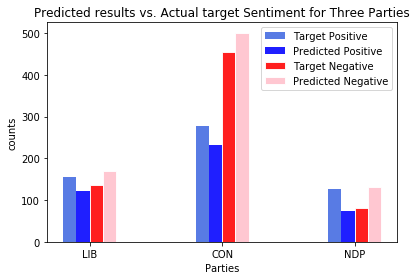

In [0]:
# plot the bar chart
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.1
opacity = 0.88

plt.bar(index-bar_width, pos_target_list, bar_width, alpha=opacity, 
        color='royalblue', label='Target Positive')
plt.bar(index, pos_predict_list, bar_width, alpha=opacity, 
         color='blue', label='Predicted Positive')


plt.bar(index+bar_width, neg_target_list, bar_width, alpha=opacity, 
        color='red', edgecolor='white', label='Target Negative')
plt.bar(index + 2*bar_width, neg_predict_list, bar_width, alpha=opacity,
        color='pink', edgecolor='white', label='Predicted Negative')

plt.xlabel('Parties')
plt.ylabel('counts')
plt.title('Predicted results vs. Actual target Sentiment for Three Parties')
plt.xticks(index + bar_width/2, ('LIB', 'CON', 'NDP'))
plt.legend()

plt.tight_layout()
plt.show()

Discussion for the plot is at the end of notebook in section :"Results"-"first model"

### Discussion

Based on the sentiment prediction results from each of the parties, it seemed that the model trained on generic tweet sentiments biased towards negative sentiments when it evaluated on the 2019 canadian election dataset. The accuracy was only at 53.118%%.

With this implementation, **I believe that NLP analytics based on tweets is not useful for political parties during election campaigns as the results obtained before are not robust enough to show whether the general public is expressing either positive or negative feelings towards a specific party.**

However, **I believe with a more sophisticated kind of implementation, NLP analytics could be useful**. 

For example, a simple procedure was designed to assign each tweet a political party label based on the keywords and hashtags used; this is not a good method as some tweets can be talking about 2 or more different political parties.
Another way to improve is to use better sentiment datasets for trainning. An example of a better dataset could include election tweets from previous years as those tweets would be more relevant in terms of the content and language used. 

Besides, we can also implement more powerful model such as RNN and deep neural nets with ngram or word embedding features.

## Negative reason prediction

In this section, three classifiers are trained to predict the negative reason of election tweets with negative sentiments. The three classifiers below are chosen for their fast training time and best performance criteria.

    - : Logistic Regression
    - : Decision Tree
    - : SVM


Because TF-IDF feature generally performs better than Word frequency, I will use **tf-idf feature** on canadian election dataset.

In [0]:
# create a dataset of cleaned election tweets that include the TF-IDF encoded tweets
elec_data_df = pd.concat([canadian_elections_final['negative_reason'], canadian_elections_final['sentiment_labels'], TFIDF_features_elec], axis=1)

# find all the negative sentiment
negative_df = elec_data_df[elec_data_df['sentiment_labels'] == 0]
negative_df.head()

# drop unecessary columns 
negative_df = negative_df.drop(['sentiment_labels'], axis=1)

In [0]:
# there are 10 different types of negative reasons
negative_df.negative_reason.value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

### Encoding 10 classes

In [0]:
# label encode the negative reasons
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Others', 0)
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Scandal', 1)
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Tell lies', 2)
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Economy', 3)
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Women Reproductive right and Racism', 4)
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Climate Problem', 5)
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Separation', 6)
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Privilege', 7)
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Healthcare', 8)
negative_df['negative_reason'] = negative_df['negative_reason'].replace('Healthcare and Marijuana', 9)

### Train test split

In [0]:
X = negative_df.drop(['negative_reason'],axis=1)
y = negative_df['negative_reason']

# split the test train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Logistic Regression Model

In [0]:
# train the logistic regression model
log_neg_model = LogisticRegression(n_jobs=-1)
log_neg_model.fit(X_train, y_train)
LR_accuracy = log_neg_model.score(X_test, y_test)
print("The accuracy of Logistic Regression Model on negative reason classification is :",LR_accuracy)

The accuracy of Logistic Regression Model on negative reason classification is : 0.49337748344370863


In [0]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, fs=(12,12),font_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=fs);
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=font_size)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=font_size-2)
    plt.xlabel('Predicted label', fontsize=font_size-2)
    plt.tight_layout()

Cross Validation Accuracy: 0.50 (+/- 0.09)


              precision    recall  f1-score   support

           0       0.56      0.60      0.58       115
           1       0.58      0.42      0.49        92
           2       0.38      0.54      0.45        54
           3       0.50      0.26      0.34        19
           4       0.25      0.43      0.32         7
           5       0.44      0.40      0.42        10
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.49       302
   macro avg       0.30      0.29      0.29       302
weighted avg       0.51      0.49      0.49       302



<Figure size 432x288 with 0 Axes>

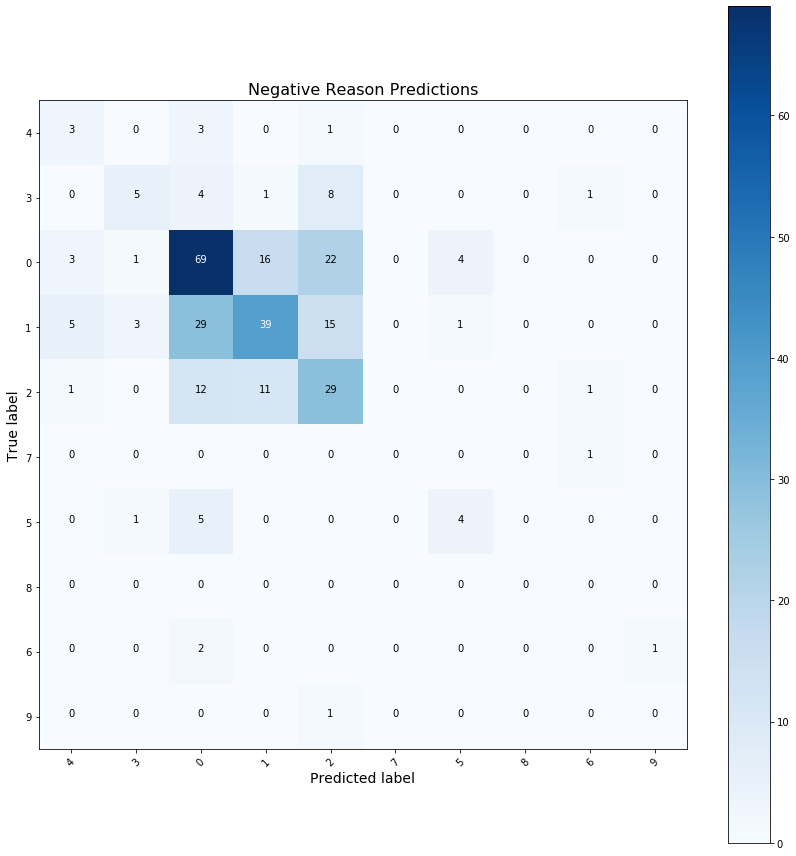

In [0]:
ticklabel=negative_df.negative_reason.unique()


log_predictions = log_neg_model.predict(X_test)
log_predictions_series = pd.Series(log_predictions)
log_predictions_series = log_predictions_series.astype(int)

scores_multi = cross_val_score(log_neg_model, X_train, y_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")
cm=confusion_matrix(y_test, log_predictions_series, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Negative Reason Predictions', fs=(12,12), font_size=16)


print(classification_report(y_test, log_predictions_series))

Logistice Regression model got 49% accuracy score when implemented to negative reason prediction, most accurate three classes are 0, 1, 2 (Others, Scandal, Tell Lies).

### Decision Tree

In [0]:
# train the decision tree model
DT_neg_model = DecisionTreeClassifier(random_state=0)
DT_neg_model.fit(X_train, y_train)
DT_accuracy = DT_neg_model.score(X_test, y_test)
print("The accuracy of Decision Tree Model on negative reason classification is :",DT_accuracy)

The accuracy of Decision Tree Model on negative reason classification is : 0.5231788079470199


Cross Validation Accuracy: 0.51 (+/- 0.11)


              precision    recall  f1-score   support

           0       0.56      0.57      0.56       115
           1       0.55      0.46      0.50        92
           2       0.52      0.59      0.55        54
           3       0.53      0.42      0.47        19
           4       0.40      0.57      0.47         7
           5       0.50      0.60      0.55        10
           6       0.11      0.33      0.17         3
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.52       302
   macro avg       0.35      0.39      0.36       302
weighted avg       0.53      0.52      0.52       302



<Figure size 432x288 with 0 Axes>

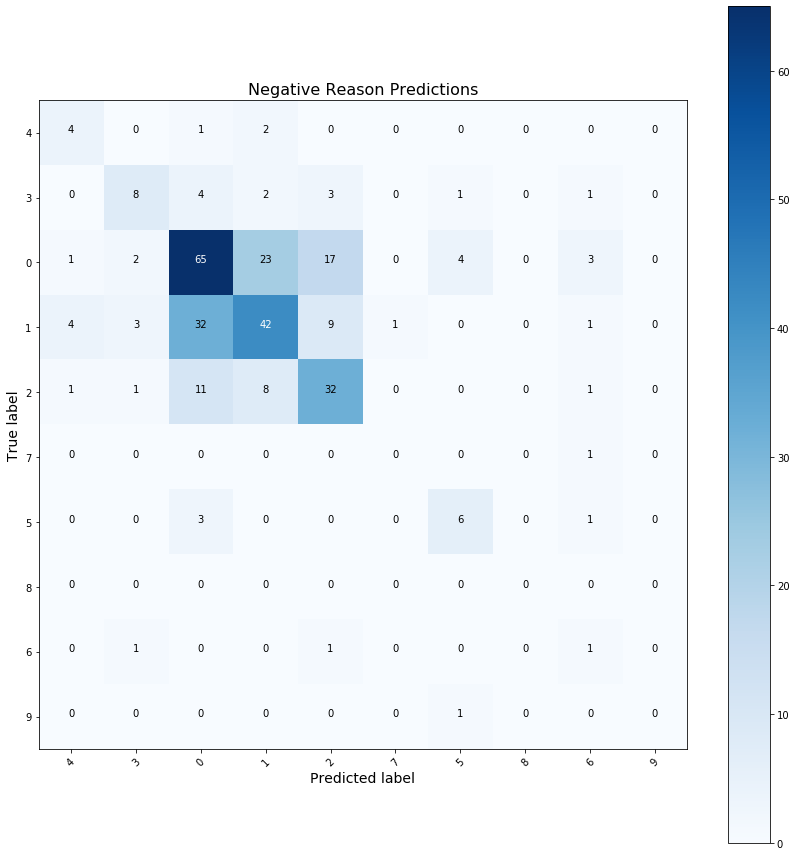

In [0]:
ticklabel=negative_df.negative_reason.unique()


DT_predictions = DT_neg_model.predict(X_test)
DT_predictions_series = pd.Series(DT_predictions)
DT_predictions_series = DT_predictions_series.astype(int)

scores_multi = cross_val_score(DT_neg_model, X_train, y_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")
cm=confusion_matrix(y_test, DT_predictions_series, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Negative Reason Predictions', fs=(12,12), font_size=16)


print(classification_report(y_test, DT_predictions_series))

Decision Tree model got 52% accuracy when implemented to negative reason prediction, most accurate three classes are 0, 1, 2 (Others, Scandal, Tell Lies).

### SVM

In [0]:
# train the SVM model
SVM_neg_model = SVC()
SVM_neg_model.fit(X_train, y_train)
SVM_accuracy = SVM_neg_model.score(X_test, y_test)
print("The accuracy of SVM Model on negative reason classification is :",SVM_accuracy)

The accuracy of SVM Model on negative reason classification is : 0.5198675496688742


Cross Validation Accuracy: 0.47 (+/- 0.11)


              precision    recall  f1-score   support

           0       0.45      0.92      0.60       115
           1       0.73      0.33      0.45        92
           2       0.89      0.31      0.47        54
           3       1.00      0.11      0.19        19
           4       1.00      0.14      0.25         7
           5       1.00      0.10      0.18        10
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.52       302
   macro avg       0.56      0.21      0.24       302
weighted avg       0.67      0.52      0.47       302



<Figure size 432x288 with 0 Axes>

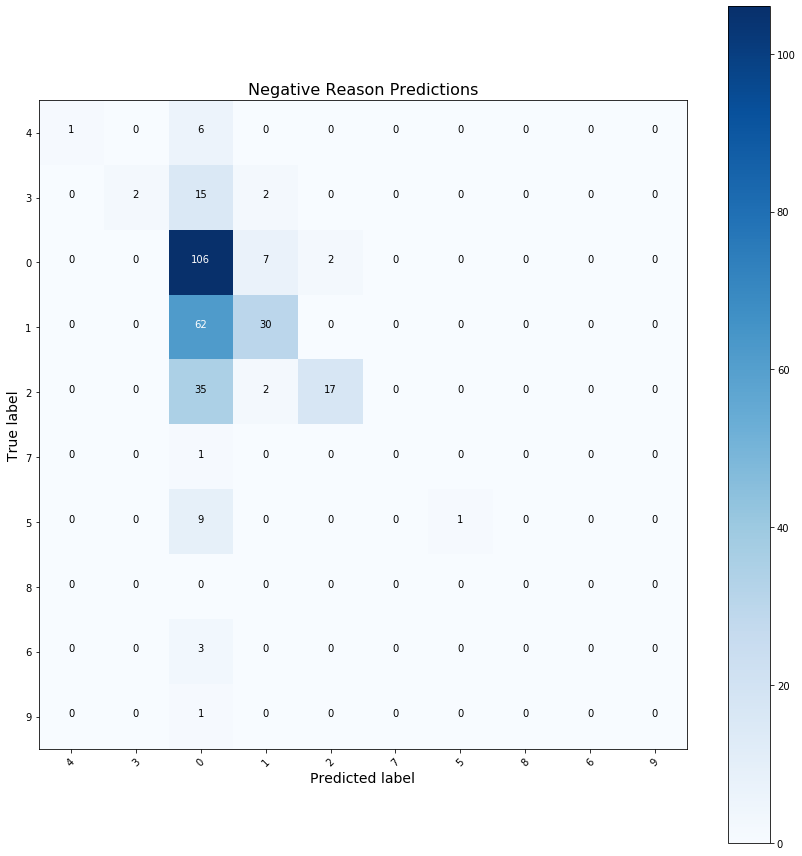

In [0]:
ticklabel=negative_df.negative_reason.unique()


SVM_predictions = SVM_neg_model.predict(X_test)
SVM_predictions_series = pd.Series(SVM_predictions)
SVM_predictions_series = SVM_predictions_series.astype(int)

scores_multi = cross_val_score(SVM_neg_model, X_train, y_train , cv=10)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print("\n")
cm=confusion_matrix(y_test, SVM_predictions_series, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Negative Reason Predictions', fs=(12,12), font_size=16)


print(classification_report(y_test, SVM_predictions_series))

SVM model got 52% accuracy when implemented to negative reason prediction, most accurate three classes are 0, 1, 2 (Others, Scandal, Tell Lies).

### **Bonus**: Word Embedding Feature for Multi-class Prediction Model

In this section, I implemented word embedding features on negative reason prediction task. Splitted the dataset into training set and test set.

In [0]:
# create a dataset of cleaned election tweets
elec_data_df = pd.concat([canadian_elections_final['negative_reason'], 
                         canadian_elections_final['sentiment_labels'] ,canadian_elections_final['cleaned_tweets']], axis=1)

# find all the negative sentiment
negative_df_emb = elec_data_df[elec_data_df['sentiment_labels'] == 0]


# drop unecessary columns 
negative_df_emb = negative_df_emb.drop(['sentiment_labels'], axis=1)

In [0]:
# label encode the negative reasons
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Others', 0)
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Scandal', 1)
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Tell lies', 2)
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Economy', 3)
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Women Reproductive right and Racism', 4)
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Climate Problem', 5)
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Separation', 6)
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Privilege', 7)
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Healthcare', 8)
negative_df_emb['negative_reason'] = negative_df_emb['negative_reason'].replace('Healthcare and Marijuana', 9)

In [0]:
#!pip install gensim
from gensim.models import word2vec
embedding = word2vec.Word2Vec(negative_df_emb.cleaned_tweets.values, size=500, min_count=1)

In [0]:
def buildWordVector(text, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        vec += embedding[word].reshape((1, size))
        count += 1.
    if count != 0:
        vec /= count
    return vec

In [0]:
negative_tweet_x = np.concatenate([buildWordVector(z, 500) for z in negative_df_emb.cleaned_tweets.values])
negative_tweet_y = negative_df_emb['negative_reason'].to_numpy()
negative_tweet_train, negative_tweet_test, negative_reason_train, negative_reason_test = train_test_split(negative_tweet_x, negative_tweet_y, test_size=0.3)

In [0]:
#example output after word embedding
negative_tweet_train

array([[-0.0121771 , -0.0239961 ,  0.01472597, ...,  0.17724045,
        -0.02360805,  0.04056523],
       [-0.01696163, -0.02661662,  0.01306603, ...,  0.18019034,
        -0.02204062,  0.04283178],
       [-0.01436177, -0.02867156,  0.01662061, ...,  0.17968905,
        -0.02401916,  0.04140863],
       ...,
       [-0.00589244, -0.02010047,  0.0166275 , ...,  0.17004718,
        -0.02605163,  0.03584241],
       [-0.00754856, -0.01893157,  0.01439107, ...,  0.16750073,
        -0.02360048,  0.03727066],
       [ 0.0059899 , -0.01410359,  0.02041171, ...,  0.15489954,
        -0.0294492 ,  0.03003714]])

#### Logistic Regression on Word Embedding Feature

In [0]:
# train the logistic regression model
log_neg_model_embedding = LogisticRegression(n_jobs=-1)
log_neg_model_embedding.fit(negative_tweet_train, negative_reason_train)
LR_accuracy_emb = log_neg_model_embedding.score(negative_tweet_test, negative_reason_test)
print("The accuracy of Logistic Regression Model on negative reason classification is :",LR_accuracy_emb)

The accuracy of Logistic Regression Model on negative reason classification is : 0.37748344370860926


#### SVM on Word Embedding Feature

In [0]:
# train the SVM model
SVM_neg_model_emb = SVC()
SVM_neg_model_emb.fit(negative_tweet_train, negative_reason_train)
SVM_accuracy_emb = SVM_neg_model_emb.score(negative_tweet_test, negative_reason_test)
print("The accuracy of SVM Model on negative reason classification is :",SVM_accuracy_emb)

The accuracy of SVM Model on negative reason classification is : 0.39403973509933776


#### Decision Tree on Word Embedding Feature

In [0]:
# train the decision tree model
DT_neg_model_emb = DecisionTreeClassifier(random_state=0)
DT_neg_model_emb.fit(negative_tweet_train, negative_reason_train)
DT_accuracy_emb = DT_neg_model_emb.score(negative_tweet_test, negative_reason_test)
print("The accuracy of Decision Tree Model on negative reason classification is :",DT_accuracy_emb)

The accuracy of Decision Tree Model on negative reason classification is : 0.25496688741721857


# Results

## First Model

**What can public opinion on Twitter tell us about the Canadian political landscape in 2019?** :

Based on the results before, the following are a few interpretations based on the analysis and results:

   - Roughly 50% of tweets about the election do not mention a specific political party. This may imply that half of the users choose to not share their political standing (perhaps this is the reason why I get poor predictions).
    
   - The tweets that mention political parties, the two most popular ones are Liberals and Conservatives. This implies that the general public are mostly divided between either Liberals or Conservatives. This makes sense as these two parties stand for opposing platforms.
   
   - There are more positive tweets than negative tweets in the canadian elections dataset. This is not an accurate representation of every election tweet as the real dataset could be imbalacned (either more positive or negative).

**how each party is viewed in the public eye based on the sentiment value?**:

**None:** As mentioned above, half of the total tweets users did not mention a political party in their tweets.

**Conservative:** Almost double the people who mention Conservatives related words have expressed negative sentiment when compared to positive sentiment. This implies that the tweets user tends to not like this political party.

**Liberal:** The public's opinion on Twitter seem to split evenly between positive and negative sentiment with regards to the Liberal party. In other words, there are even amount of people who like and dislike this party.

**NDP:** This is the only political party that the public's opinion on Twitter are generally positive with more than double the amount when compared to the negative tweets.

Majority of people who mention a political party are either Conservative or Liberal, and the fact that most people mentioning Conservatives are negative, Thus, winner of the 2019 election winner is from the Liberal political party.


## Second Model

**Based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons:**


*   The three models that I implemented to predict the negative reasons (logistic regression, decision trees and SVM), SVM model performed best which  at approximately 53% accuracy. Based on the confusion matrix in that section, it can be seen that the class 0, 1, 2 (Others, Scandal, Tell Lies) were predicted well while the last 6 did not do so well. This is primarily due to the fact that the dataset was imbalanced, each class does not have equally number of samples. 

There are significantly more samples belonging to the first 3 kinds of negative reasons; therefore, the model learned to predict these three classes more.



## For both models, suggest one way you can improve the accuracy of your models:

In order to improve the prediction of sentiment and negative reason on the elections data, the following may help to get better prediction results.

   - **First model: Sentiment Prediction**
       - I believe using election data from previous years to train the sentiment prediction model would yield a higher accuracy when evaluated on this year's election because the model would be able to learn more meaningful/relevant information from election-type tweets.
       - I can also improve the accuracy of this model is that I could use a deeper complex model, such as RNN. RNN is a better model for natural language processing, as well as sentiment analysis.
       
   - **Second model: Negative Reason Prediction**
       - The main reason why the negative reason prediction did not do so well  is because of an **imbalanced** dataset. There are not enough samples that support the other 6 reasons (besides Others, Scandal, Tell Lies); therefore, the model was not able to accurately learn how to predict those reasons.
       - So a more balanced dataset would improve the overall accuracy (equal amount of samples for every negative reason)
       - Another solution would be to categorize the negative reasons in to fewer classes to even out the differences in number of samples. This will provide the model with enough data to correctly learn how to predict each negative reason.
       - The best way to improve the accuracy of this model is to get more data that has negative reasons other than "Other". 